<a href="https://colab.research.google.com/github/sydney-machine-learning/cyclonegenesis_seasurfacetemperature/blob/albert/Climate%20Project/albert/notebooks/Copy_of_Bayesian_Regression_WIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro

  Preparing metadata (setup.py) ... done


In [3]:
import os
# cpu cores available for sampling (we want this to equal num_chains)
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=4'

from IPython.display import set_matplotlib_formats
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import arviz as az
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive


In [4]:
DATASET_URL = "https://raw.githubusercontent.com/sydney-machine-learning/cyclonegenesis_seasurfacetemperature/albert/Climate%20Project/albert/cyclone_data/jtwc/cleaned/full_cleaned.csv"
dset = pd.read_csv(DATASET_URL)
# rename columns
dset.columns = dset.columns.str.replace(' ', '_').str.replace('(','').str.replace(')','').str.lower()
dset

<ipython-input-4-ea81969726dc>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dset.columns = dset.columns.str.replace(' ', '_').str.replace('(','').str.replace(')','').str.lower()
<ipython-input-4-ea81969726dc>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dset.columns = dset.columns.str.replace(' ', '_').str.replace('(','').str.replace(')','').str.lower()


,unnamed:_0,timestamp,storm_id,basin,season,season_tc_number,stormname,latitude_degrees,longitude_degrees,vmax_kt,peak_vmax_kt,ace,maximum_24h_intensification,tropical_sst,local_sst,local_month_mean
0,921,1982-08-04 12:00:00,1982-N-12,WP,1982.0,12.0,NaN,19.8,130.9,20.0,125.0,2.14875,45.0,27.565964,28.316607,29.196020
1,922,1982-08-08 00:00:00,1982-N-13,WP,1982.0,13.0,NaN,7.7,153.9,20.0,80.0,0.86525,25.0,27.565964,28.282774,29.311720
2,923,1982-08-17 06:00:00,1982-N-14,WP,1982.0,14.0,NaN,8.2,154.2,20.0,125.0,2.72850,25.0,27.565964,28.308462,29.301773
3,924,1982-08-20 00:00:00,1982-N-15,WP,1982.0,15.0,NaN,11.3,124.8,20.0,90.0,1.47000,35.0,27.565964,28.343359,29.167967
4,925,1982-08-27 00:00:00,1982-N-16,WP,1982.0,16.0,NaN,14.6,153.8,30.0,100.0,2.33900,30.0,27.565964,28.092667,29.231500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1779,1877,2022-10-14 06:00:00,2022-N-24,WP,2022.0,24.0,INVEST,26.4,154.4,25.0,40.0,0.19675,15.0,27.681841,28.137896,27.757618
1780,1878,2022-10-26 00:00:00,2022-N-26,WP,2022.0,26.0,INVEST,12.2,133.8,20.0,75.0,0.67825,25.0,27.681841,29.645842,29.207080
1781,1879,2022-10-28 12:00:00,2022-N-27,WP,2022.0,27.0,INVEST,8.0,140.4,25.0,40.0,0.10875,15.0,27.681841,29.821840,29.312254
1782,1880,2022-11-11 18:00:00,2022-N-28,WP,2022.0,28.0,INVEST,20.2,166.3,20.0,40.0,0.10600,10.0,27.664591,28.148760,27.703903


In [5]:
standardize = lambda x: (x - x.mean()) / x.std()

## FOR NUMERICAL STABILITY
dset["tropical_sst_scaled"] = dset.tropical_sst.pipe(standardize)
dset["local_sst_scaled"] = dset.local_sst.pipe(standardize)
dset["peak_wind_scaled"] = dset.peak_vmax_kt.pipe(lambda x: standardize(x))

In [6]:
def model(tropical_sst=None, local_sst=None, peak_wind=None, q=None):
    if q is None:
      q = 0.5

    intercept = numpyro.sample("intercept", dist.ImproperUniform(dist.constraints.real, (), event_shape=()))

    TROPICAL_COMPONENT = 0.0
    LOCAL_COMPONENT = 0.0

    if tropical_sst is not None:
        tropical_coef = numpyro.sample("tropical_coef", dist.ImproperUniform(dist.constraints.real, (), event_shape=()))
        TROPICAL_COMPONENT = tropical_coef * tropical_sst

    if local_sst is not None:
        local_coef = numpyro.sample("local_coef", dist.ImproperUniform(dist.constraints.real, (), event_shape=()))
        LOCAL_COMPONENT = local_coef * local_sst

    # use a uniform prior instead??
    mu = intercept + TROPICAL_COMPONENT + LOCAL_COMPONENT
    numpyro.deterministic("mu", mu)

   # THIS IS WHERE THE QUANTILE REGRESSION COMES IN
    obs = numpyro.sample('obs', dist.AsymmetricLaplaceQuantile(loc=mu, scale=1.0,quantile=q), obs=peak_wind)

In [33]:
rng_key = random.PRNGKey(0)

qs = np.linspace(0.1, 0.95, 10)
params = {}

for q in qs:
    rng_key, rng_key_ = random.split(rng_key)
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_chains=4, num_warmup=500, num_samples=500, progress_bar=True)
    mcmc.run(
        rng_key_,
        tropical_sst=dset.tropical_sst_scaled.values,
        local_sst=dset.local_sst_scaled.values,
        peak_wind=dset.peak_wind_scaled.values,
        q=q )
    mcmc_samples = mcmc.get_samples()
    params[q] = mcmc_samples
    print(q)
    mcmc.print_summary()
    print()

    posterior_predictive = Predictive(
        model, posterior_samples=mcmc_samples,
        # return_sites=extract_vars
    )(rng_key_,
      tropical_sst = dset.tropical_sst_scaled.values,
      local_sst    = dset.local_sst_scaled.values,
      peak_wind    = dset.peak_wind_scaled.values,
      q            = q
    )
    arviz_posterior = az.from_numpyro(
            mcmc,
            posterior_predictive=posterior_predictive,
            # coords=az_coords,
            # dims=az_dims
    )
    params[q] = arviz_posterior
    print(q)
    mcmc.print_summary()
    print()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.1

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
      intercept     -1.17      0.03     -1.17     -1.21     -1.13   1418.15      1.01
     local_coef      0.02      0.03      0.02     -0.03      0.06   1319.92      1.00
  tropical_coef     -0.02      0.03     -0.02     -0.07      0.03   1544.03      1.00

Number of divergences: 0

0.1

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
      intercept     -1.17      0.03     -1.17     -1.21     -1.13   1418.15      1.01
     local_coef      0.02      0.03      0.02     -0.03      0.06   1319.92      1.00
  tropical_coef     -0.02      0.03     -0.02     -0.07      0.03   1544.03      1.00

Number of divergences: 0



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.19444444444444445

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
      intercept     -1.01      0.03     -1.00     -1.06     -0.95   1600.44      1.00
     local_coef      0.05      0.03      0.05     -0.01      0.10   1197.07      1.00
  tropical_coef     -0.03      0.03     -0.03     -0.09      0.02   1343.52      1.01

Number of divergences: 0

0.19444444444444445

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
      intercept     -1.01      0.03     -1.00     -1.06     -0.95   1600.44      1.00
     local_coef      0.05      0.03      0.05     -0.01      0.10   1197.07      1.00
  tropical_coef     -0.03      0.03     -0.03     -0.09      0.02   1343.52      1.01

Number of divergences: 0



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.28888888888888886

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
      intercept     -0.82      0.03     -0.82     -0.88     -0.77   1382.09      1.00
     local_coef      0.06      0.04      0.06      0.00      0.12   1212.81      1.00
  tropical_coef     -0.03      0.04     -0.03     -0.09      0.03   1230.00      1.00

Number of divergences: 0

0.28888888888888886

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
      intercept     -0.82      0.03     -0.82     -0.88     -0.77   1382.09      1.00
     local_coef      0.06      0.04      0.06      0.00      0.12   1212.81      1.00
  tropical_coef     -0.03      0.04     -0.03     -0.09      0.03   1230.00      1.00

Number of divergences: 0



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.3833333333333333

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
      intercept     -0.56      0.04     -0.56     -0.62     -0.50   1426.93      1.00
     local_coef      0.11      0.04      0.11      0.03      0.17   1059.20      1.00
  tropical_coef     -0.06      0.04     -0.06     -0.13      0.00   1189.94      1.00

Number of divergences: 0

0.3833333333333333

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
      intercept     -0.56      0.04     -0.56     -0.62     -0.50   1426.93      1.00
     local_coef      0.11      0.04      0.11      0.03      0.17   1059.20      1.00
  tropical_coef     -0.06      0.04     -0.06     -0.13      0.00   1189.94      1.00

Number of divergences: 0



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.47777777777777775

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
      intercept     -0.26      0.04     -0.26     -0.33     -0.19   1637.90      1.00
     local_coef      0.16      0.04      0.16      0.09      0.23   1490.11      1.00
  tropical_coef     -0.03      0.04     -0.03     -0.10      0.03   1482.21      1.00

Number of divergences: 0

0.47777777777777775

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
      intercept     -0.26      0.04     -0.26     -0.33     -0.19   1637.90      1.00
     local_coef      0.16      0.04      0.16      0.09      0.23   1490.11      1.00
  tropical_coef     -0.03      0.04     -0.03     -0.10      0.03   1482.21      1.00

Number of divergences: 0



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.5722222222222222

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
      intercept      0.07      0.05      0.07     -0.00      0.15   1523.05      1.00
     local_coef      0.16      0.05      0.16      0.08      0.24   1500.92      1.00
  tropical_coef      0.02      0.05      0.02     -0.07      0.09   1141.78      1.00

Number of divergences: 0

0.5722222222222222

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
      intercept      0.07      0.05      0.07     -0.00      0.15   1523.05      1.00
     local_coef      0.16      0.05      0.16      0.08      0.24   1500.92      1.00
  tropical_coef      0.02      0.05      0.02     -0.07      0.09   1141.78      1.00

Number of divergences: 0



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.6666666666666666

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
      intercept      0.49      0.05      0.48      0.40      0.56   1562.18      1.00
     local_coef      0.12      0.06      0.12      0.02      0.22   1559.68      1.00
  tropical_coef      0.07      0.05      0.07     -0.02      0.15   1582.08      1.00

Number of divergences: 0

0.6666666666666666

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
      intercept      0.49      0.05      0.48      0.40      0.56   1562.18      1.00
     local_coef      0.12      0.06      0.12      0.02      0.22   1559.68      1.00
  tropical_coef      0.07      0.05      0.07     -0.02      0.15   1582.08      1.00

Number of divergences: 0



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.7611111111111111

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
      intercept      0.90      0.05      0.90      0.83      0.98   1222.17      1.00
     local_coef      0.15      0.05      0.15      0.06      0.23   1349.52      1.00
  tropical_coef      0.09      0.05      0.09     -0.01      0.17   1494.92      1.00

Number of divergences: 0

0.7611111111111111

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
      intercept      0.90      0.05      0.90      0.83      0.98   1222.17      1.00
     local_coef      0.15      0.05      0.15      0.06      0.23   1349.52      1.00
  tropical_coef      0.09      0.05      0.09     -0.01      0.17   1494.92      1.00

Number of divergences: 0



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.8555555555555555

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
      intercept      1.27      0.05      1.27      1.20      1.36   1540.71      1.00
     local_coef      0.16      0.06      0.16      0.06      0.24   1486.33      1.00
  tropical_coef      0.06      0.06      0.06     -0.03      0.16   1517.56      1.00

Number of divergences: 0

0.8555555555555555

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
      intercept      1.27      0.05      1.27      1.20      1.36   1540.71      1.00
     local_coef      0.16      0.06      0.16      0.06      0.24   1486.33      1.00
  tropical_coef      0.06      0.06      0.06     -0.03      0.16   1517.56      1.00

Number of divergences: 0



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.95

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
      intercept      1.72      0.06      1.72      1.63      1.81   1508.87      1.00
     local_coef      0.15      0.07      0.15      0.03      0.25   1599.27      1.00
  tropical_coef      0.06      0.06      0.06     -0.05      0.16   1392.44      1.00

Number of divergences: 0

0.95

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
      intercept      1.72      0.06      1.72      1.63      1.81   1508.87      1.00
     local_coef      0.15      0.07      0.15      0.03      0.25   1599.27      1.00
  tropical_coef      0.06      0.06      0.06     -0.05      0.16   1392.44      1.00

Number of divergences: 0



In [34]:
arviz_posterior

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [35]:
sample = params[q]
sample.posterior_predictive['mu'].mean(dim=['chain','draw']).values

array([1.5425576, 1.5347341, 1.5406739, ..., 1.9160666, 1.5253035,
       1.8879111], dtype=float32)

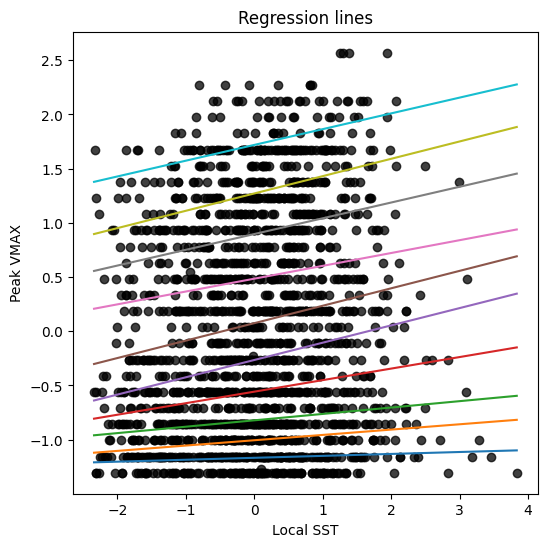

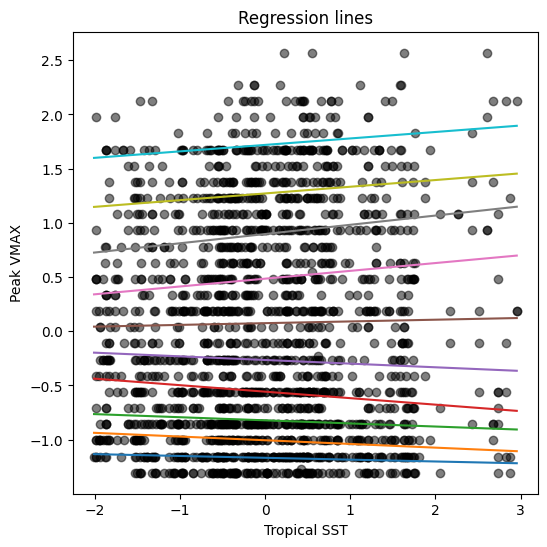

In [36]:
def plot_regression(x, post_mean, ax):
    # Sort values for plotting by x axis
    idx = jnp.argsort(x)
    x_ordered = x[idx]
    post_mean = post_mean[idx]

    ax.plot(x_ordered, post_mean)

# Compute empirical posterior distribution over mu
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
ax.plot(dset.local_sst_scaled.values, dset.peak_wind_scaled.values, "ko", alpha=0.75)
ax.set(
    xlabel="Local SST", ylabel="Peak VMAX", title="Regression lines"
)
for q in qs:
    sample = params[q]
    mean_beta = sample.posterior['local_coef'].mean().values
    mean_intercept = sample.posterior['intercept'].mean().values
    intercept_vec = np.ones(dset.shape[0]) * mean_intercept
    lin_vec = dset.local_sst_scaled.values * mean_beta

    post_mean = intercept_vec + lin_vec

    plot_regression(dset.local_sst_scaled.values, post_mean, ax)


plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
ax.plot(dset.tropical_sst_scaled.values, dset.peak_wind_scaled.values, "ko",alpha=0.5)
ax.set(
    xlabel="Tropical SST", ylabel="Peak VMAX", title="Regression lines"
);

for q in qs:
    sample = params[q]
    mean_beta = sample.posterior['tropical_coef'].mean().values
    mean_intercept = sample.posterior['intercept'].mean().values
    intercept_vec = np.ones(dset.shape[0]) * mean_intercept
    lin_vec = dset.tropical_sst_scaled.values * mean_beta

    post_mean = intercept_vec + lin_vec

    plot_regression(dset.tropical_sst_scaled.values, post_mean, ax)


plt.show()

## What do the posteriors look like for different quantiles??


In [37]:
## JOIN QUANTILES TO A COMMON

## this just eats up ram...
import xarray as xr
# # xarray to DF
common_dataset = None
for q in qs:
  quantile_dataset = params[q].posterior
  quantile_dataset = quantile_dataset.expand_dims(dim={"quantile": [q]}, axis=0)

  if common_dataset is None:
    common_dataset = quantile_dataset
  else:
    common_dataset = xr.concat([common_dataset, quantile_dataset], dim="y")

common_dataset

<xarray.Dataset>
Dimensions:        (chain: 4, draw: 500, mu_dim_0: 1784, quantile: 10, y: 10)
Coordinates:
  * chain          (chain) int64 0 1 2 3
  * draw           (draw) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * mu_dim_0       (mu_dim_0) int64 0 1 2 3 4 5 ... 1779 1780 1781 1782 1783
  * quantile       (quantile) float64 0.1 0.1944 0.2889 ... 0.7611 0.8556 0.95
Dimensions without coordinates: y
Data variables:
    intercept      (y, quantile, chain, draw) float32 -1.186 -1.174 ... 1.732
    local_coef     (y, quantile, chain, draw) float32 -0.01269 ... 0.1968
    mu             (y, quantile, chain, draw, mu_dim_0) float32 -1.166 ... 1.963
    tropical_coef  (y, quantile, chain, draw) float32 -0.01578 ... 0.01388
Attributes:
    created_at:                 2023-10-04T23:19:57.094434
    arviz_version:              0.15.1
    inference_library:          numpyro
    inference_library_version:  0.13.2

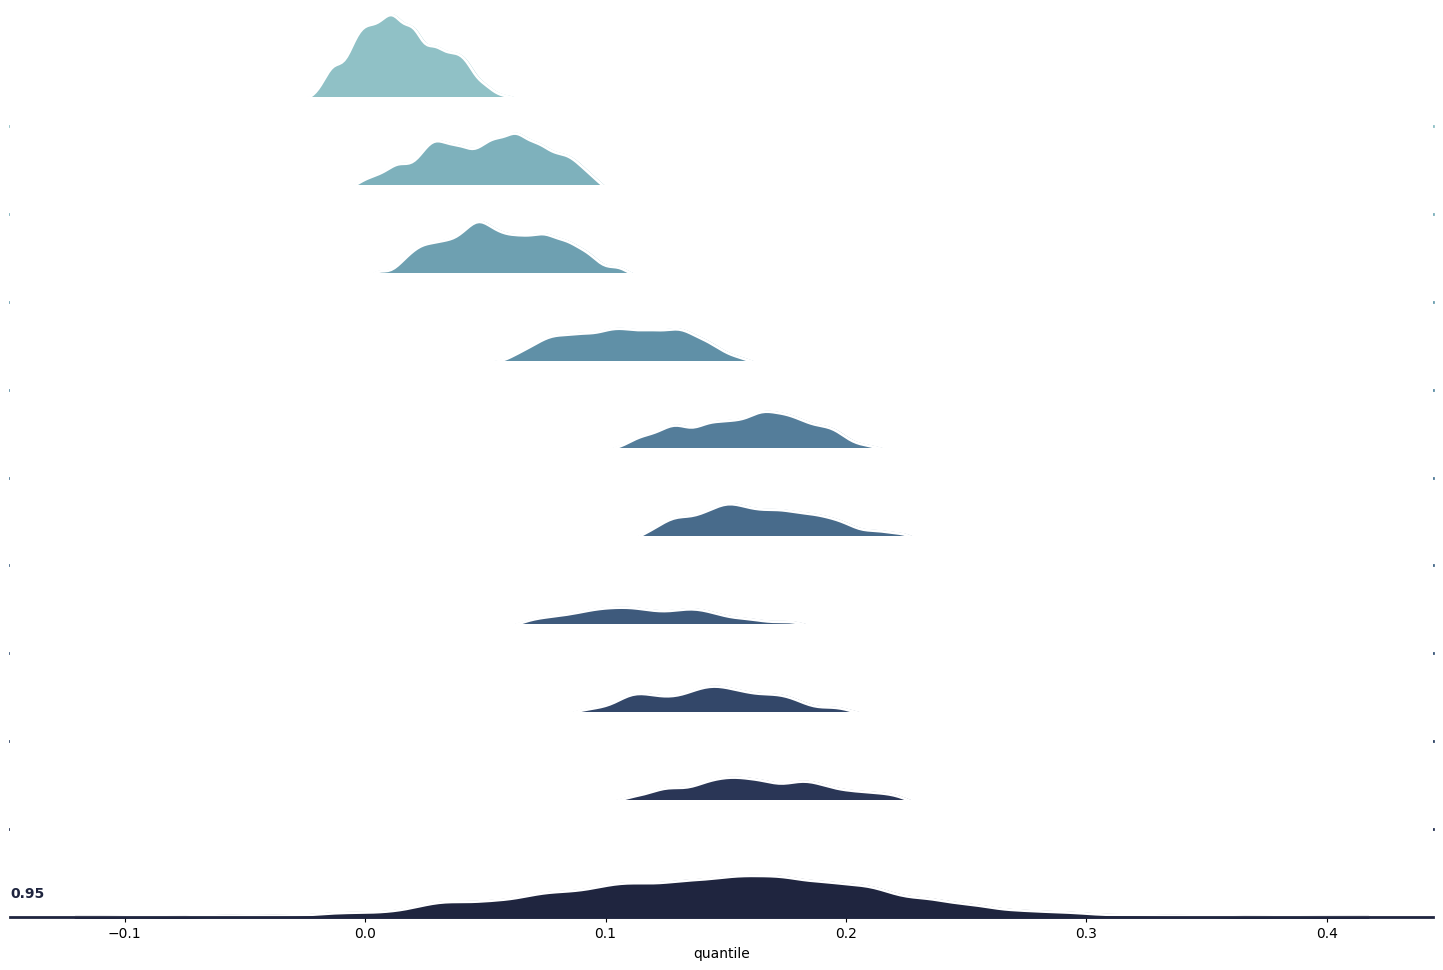

In [38]:
local_coef_df = common_dataset['local_coef'].to_dataframe().reset_index()

pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

g = sns.FacetGrid(local_coef_df, row="quantile", hue="quantile", aspect=15, height=1, palette=pal)

g.map(sns.kdeplot, "local_coef",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=2)

g.map(sns.kdeplot, "local_coef", clip_on=False, color="w", lw=2, bw_adjust=.5)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "quantile")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

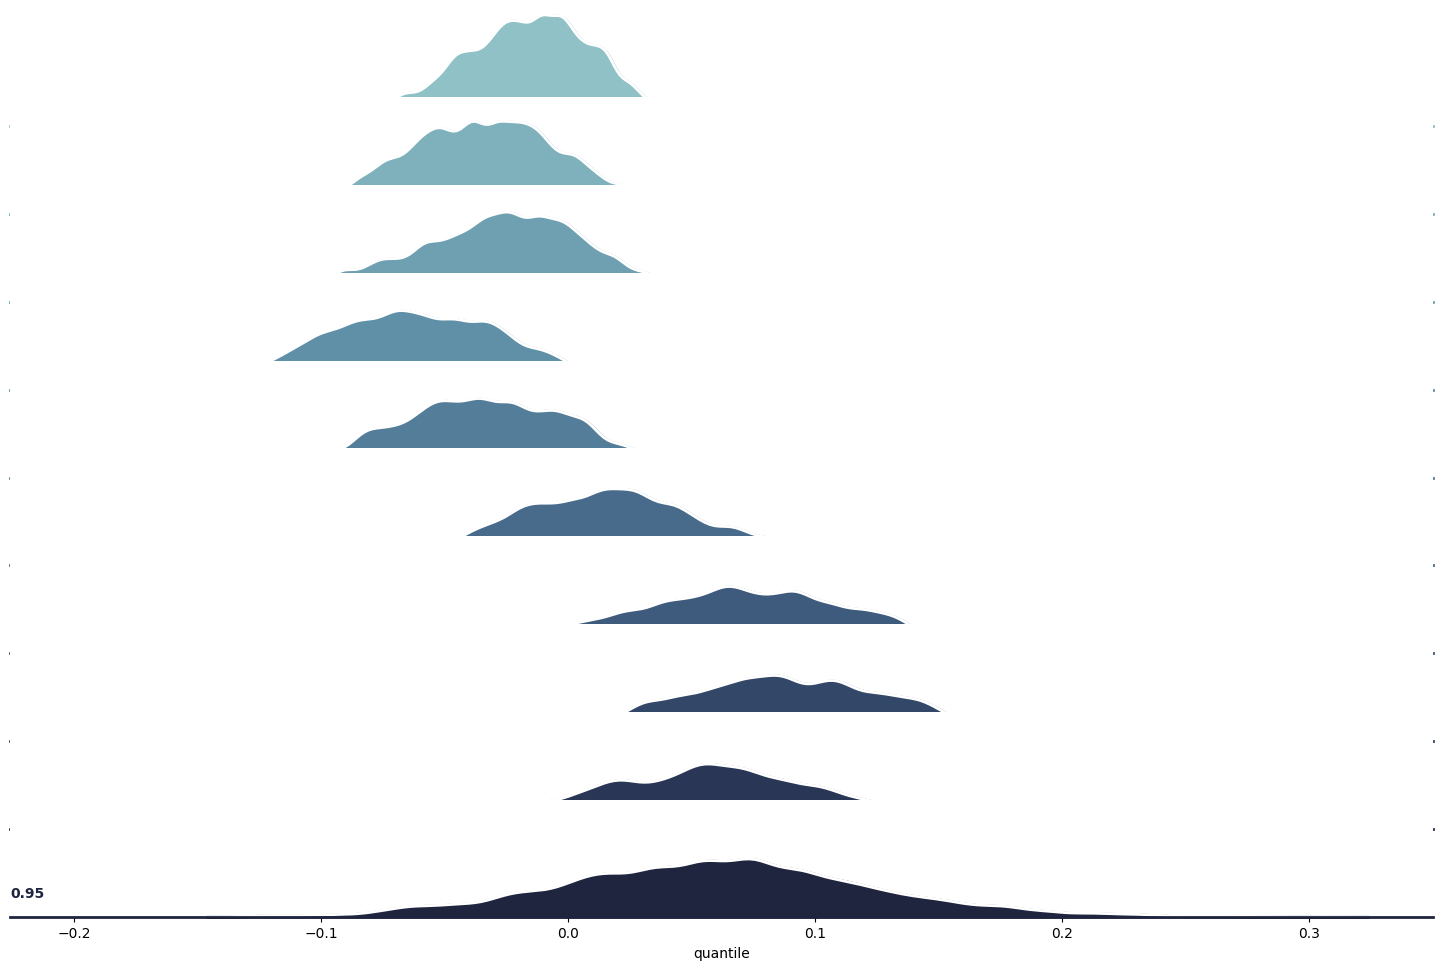

In [39]:
local_coef_df = common_dataset['tropical_coef'].to_dataframe().reset_index()

pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

g = sns.FacetGrid(local_coef_df, row="quantile", hue="quantile", aspect=15, height=1, palette=pal)

g.map(sns.kdeplot, "tropical_coef",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=2)

g.map(sns.kdeplot, "tropical_coef", clip_on=False, color="w", lw=2, bw_adjust=.5)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "quantile")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)